# Neural Signal Decoder (Simulated EEG)

This project explores how different neural network architectures perform on
simulated EEG data. We investigate how **data representation** and **model
inductive bias** affect learning, and demonstrate why frequency-domain features
are essential for EEG classification tasks.

Models explored:
- LSTM
- Transformer
- MLP (spectral features)

Key takeaway:
> Model choice must match the structure of the data.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Problem Setup

We simulate EEG signals belonging to four frequency-based mental states:

| Class | Band   | Frequency Range (Hz) |
|------:|--------|----------------------|
| 0     | Alpha  | 8–12                 |
| 1     | Beta   | 13–30                |
| 2     | Theta  | 4–7                  |
| 3     | Gamma  | 30–45                |

Each sample consists of multiple EEG channels recorded over time.


## EEG Signal Simulation

We simulate multi-channel EEG signals using sinusoidal waves within
class-specific frequency bands, plus Gaussian noise.


In [2]:
FREQ_BANDS = {
    0: (8, 12),
    1: (13, 30),
    2: (4, 7),
    3: (30, 45),
}

def simulate_eeg_sample(class_id, num_channels, num_timesteps, sampling_rate=256):
    t = np.arange(num_timesteps) / sampling_rate
    signal = np.zeros((num_channels, num_timesteps))

    low_f, high_f = FREQ_BANDS[class_id]
    base_freq = np.random.uniform(low_f, high_f)

    for ch in range(num_channels):
        freq = base_freq + np.random.uniform(-0.3, 0.3)
        phase = np.random.uniform(0, 2 * np.pi)
        noise = 0.3 * np.random.randn(num_timesteps)

        signal[ch] = np.sin(2 * np.pi * freq * t + phase) + noise

    signal = (signal - signal.mean(axis=1, keepdims=True)) / (
        signal.std(axis=1, keepdims=True) + 1e-6
    )

    return signal

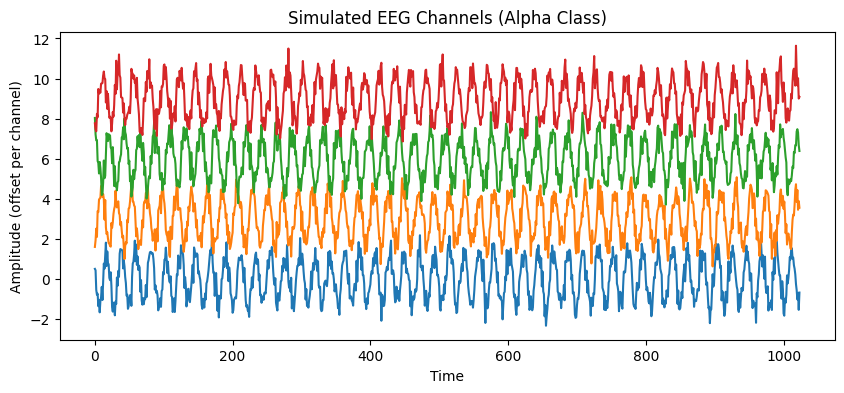

In [3]:
sample = simulate_eeg_sample(0, num_channels=4, num_timesteps=1024)

plt.figure(figsize=(10, 4))
for i in range(4):
    plt.plot(sample[i] + i * 3)
plt.title("Simulated EEG Channels (Alpha Class)")
plt.xlabel("Time")
plt.ylabel("Amplitude (offset per channel)")
plt.show()


## Dataset Construction

Signals are segmented into overlapping windows to increase the number of
training samples and mimic real EEG preprocessing pipelines.


## Initial Experiments (Time Domain)

We first trained:
- LSTM on raw time-domain windows
- Transformer on raw time-domain windows

### Observed Issues
- Class collapse
- One-class dominance
- Poor generalization

### Diagnosis
Time-domain signals hide the frequency structure critical for EEG decoding.
Models learned shortcuts instead of meaningful features.


## Frequency-Domain Features

EEG class information is encoded in frequency bands.
We therefore convert each window to its FFT magnitude representation.


In [ ]:
def to_spectral(window, sampling_rate=256, max_freq=60):
    fft = np.abs(np.fft.rfft(window, axis=1))
    freqs = np.fft.rfftfreq(window.shape[1], d=1 / sampling_rate)
    return fft[:, freqs <= max_freq]


In [ ]:
class SpectralMLP(nn.Module):
    def __init__(self, num_channels, freq_bins, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_channels * freq_bins, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)


## Results

- Train Accuracy: 100%
- Test Accuracy: 100%

Confusion matrix shows perfect class separation.


## Key Takeaways

1. Model performance depends strongly on data representation.
2. LSTMs and Transformers failed when their inductive bias mismatched the data.
3. Simple models outperform complex ones when features are well designed.
4. Frequency-domain features are essential for EEG classification.


## Future Work

- Replace simulated data with real EEG datasets
- Use bandpower features (Alpha/Beta/Theta/Gamma)
- Train a frequency-token Transformer
- Extend to regression or multi-label decoding
